In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 건강검진 데이터를 이용하여 당뇨병을 예측하는 모델

- 상황 가정 : 건강검진 데이터를 제공 받았으나 전산사의 오류로 당뇨병을 간단하게 판별할 수 있는 공복 혈당 수치의 데이터가 손실됨
- 이때 나머지 건강검진 데이터를 이용하여 이 사람이 당뇨인지 아닌지를 예측하고 그 확률을 보여주는 모델을 제공하자
- 모델을 학습시킬 땐 공복혈당 수치 데이터가 손실되지 않았던 예전 데이터를 사용한다고 가정

In [60]:
origin = pd.read_csv("./data/Origin.csv")
origin_df = origin.copy()

In [61]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   HCHK_YEAR          1000000 non-null  int64  
 1   IDV_ID             1000000 non-null  int64  
 2   SIDO               1000000 non-null  int64  
 3   SEX                1000000 non-null  int64  
 4   AGE_GROUP          1000000 non-null  int64  
 5   HEIGHT             1000000 non-null  int64  
 6   WEIGHT             1000000 non-null  int64  
 7   WAIST              999917 non-null   float64
 8   SIGHT_LEFT         999789 non-null   float64
 9   SIGHT_RIGHT        999790 non-null   float64
 10  HEAR_LEFT          999810 non-null   float64
 11  HEAR_RIGHT         999811 non-null   float64
 12  BP_HIGH            992655 non-null   float64
 13  BP_LWST            992655 non-null   float64
 14  BLDS               992588 non-null   float64
 15  TOT_CHOLE          425059 non-nul

In [62]:
origin.head()

,HCHK_YEAR,IDV_ID,SIDO,SEX,AGE_GROUP,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,...,GAMMA_GTP,SMK_STAT_TYPE_CD,DRK_YN,HCHK_OE_INSPEC_YN,CRS_YN,TTH_MSS_YN,ODT_TRB_YN,WSDM_DIS_YN,TTR_YN,DATA_STD_DT
0,2021,2551207,41,2,12,160,60,79.0,0.0,0.0,...,23.0,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,2022-08-11
1,2021,4030716,41,2,11,160,60,74.0,0.0,0.0,...,12.0,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN,2022-08-11
2,2021,3297511,41,2,9,150,60,72.0,0.0,0.0,...,70.0,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN,2022-08-11
3,2021,1638533,41,2,16,150,60,86.0,0.0,0.0,...,24.0,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,2022-08-11
4,2021,456602,41,2,13,155,60,66.0,0.0,0.0,...,12.0,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN,2022-08-11


### 날짜를 제외한 데이터는 모두 수치형 자료이므로 날짜 컬럼을 제외
- 년도, 검사자 ID, SIDO 코드또한 의미 없는 인덱스이므로 제외함

In [63]:
origin_df = origin_df.drop(['DATA_STD_DT','HCHK_YEAR','IDV_ID','SIDO'],axis=1)

In [64]:
origin_df

,SEX,AGE_GROUP,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,HEAR_LEFT,HEAR_RIGHT,BP_HIGH,...,SGPT_ALT,GAMMA_GTP,SMK_STAT_TYPE_CD,DRK_YN,HCHK_OE_INSPEC_YN,CRS_YN,TTH_MSS_YN,ODT_TRB_YN,WSDM_DIS_YN,TTR_YN
0,2,12,160,60,79.0,0.0,0.0,1.0,1.0,101.0,...,21.0,23.0,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN
1,2,11,160,60,74.0,0.0,0.0,1.0,1.0,121.0,...,21.0,12.0,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN
2,2,9,150,60,72.0,0.0,0.0,1.0,1.0,135.0,...,26.0,70.0,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN
3,2,16,150,60,86.0,0.0,0.0,1.0,1.0,130.0,...,9.0,24.0,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN
4,2,13,155,60,66.0,0.0,0.0,1.0,1.0,120.0,...,19.0,12.0,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2,14,150,60,91.0,0.0,0.0,1.0,1.0,156.0,...,122.0,32.0,1.0,0.0,1,0.0,NaN,NaN,NaN,0.0
999996,1,9,170,100,99.0,1.0,1.0,1.0,1.0,134.0,...,115.0,73.0,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN
999997,2,10,150,75,98.0,0.0,0.0,1.0,1.0,142.0,...,107.0,70.0,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN
999998,2,10,160,55,70.0,0.0,0.0,1.0,1.0,132.0,...,117.0,140.0,1.0,0.0,1,0.0,NaN,NaN,NaN,0.0


### 우리가 가진 데이터중에서 당뇨를 판정할 수 있는 컬럼은 'BLDS'로 공복혈당 수치를 말한다.
![diabete1](https://cdn.discordapp.com/attachments/1164889522488754297/1179687163940569150/image.png?ex=657ab049&is=65683b49&hm=f700a9131a4bc882728fddf1b330c012fb54bc50d887f9ad87f4bac559f75377&)

- 따라서 'BLDS'의 수치가 126이 넘어가면 당뇨라고 판단, 새로운 컬럼을 만들어 1을 부여하고 126 미만이면 0으로 처리한다.

In [65]:
origin_df['D'] = np.where(origin_df['BLDS'] > 126, 1,0)
origin_df.head()

,SEX,AGE_GROUP,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,HEAR_LEFT,HEAR_RIGHT,BP_HIGH,...,GAMMA_GTP,SMK_STAT_TYPE_CD,DRK_YN,HCHK_OE_INSPEC_YN,CRS_YN,TTH_MSS_YN,ODT_TRB_YN,WSDM_DIS_YN,TTR_YN,D
0,2,12,160,60,79.0,0.0,0.0,1.0,1.0,101.0,...,23.0,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,0
1,2,11,160,60,74.0,0.0,0.0,1.0,1.0,121.0,...,12.0,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN,0
2,2,9,150,60,72.0,0.0,0.0,1.0,1.0,135.0,...,70.0,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN,0
3,2,16,150,60,86.0,0.0,0.0,1.0,1.0,130.0,...,24.0,1.0,0.0,0,NaN,NaN,NaN,NaN,NaN,1
4,2,13,155,60,66.0,0.0,0.0,1.0,1.0,120.0,...,12.0,1.0,1.0,0,NaN,NaN,NaN,NaN,NaN,0


### 결측치를 확인하고 적절하게 처리

In [66]:
origin_df.isna().sum()

SEX                        0
AGE_GROUP                  0
HEIGHT                     0
WEIGHT                     0
WAIST                     83
SIGHT_LEFT               211
SIGHT_RIGHT              210
HEAR_LEFT                190
HEAR_RIGHT               189
BP_HIGH                 7345
BP_LWST                 7345
BLDS                    7412
TOT_CHOLE             574941
TRIGLYCERIDE          574945
HDL_CHOLE             574945
LDL_CHOLE             582568
HMG                     7414
OLIG_PROTE_CD          12561
CREATININE              7407
SGOT_AST                7405
SGPT_ALT                7405
GAMMA_GTP               7406
SMK_STAT_TYPE_CD         370
DRK_YN                   168
HCHK_OE_INSPEC_YN          0
CRS_YN                683234
TTH_MSS_YN           1000000
ODT_TRB_YN           1000000
WSDM_DIS_YN          1000000
TTR_YN                683233
D                          0
dtype: int64

- 확인 결과 'TTH_MSS_YN' 'ODT_TRB_YN' 'WSDM_DIS_YN' 모두 결측치이므로 제거

In [67]:
origin_df = origin_df.drop(['TTH_MSS_YN','ODT_TRB_YN','WSDM_DIS_YN'],axis=1)

In [68]:
origin_df.insert(0, 'BLDS', origin_df.pop('BLDS'))
origin_df.insert(1, 'D', origin_df.pop('D'))

In [69]:
origin_df.head()

,BLDS,D,SEX,AGE_GROUP,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,HEAR_LEFT,...,OLIG_PROTE_CD,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT_TYPE_CD,DRK_YN,HCHK_OE_INSPEC_YN,CRS_YN,TTR_YN
0,93.0,0,2,12,160,60,79.0,0.0,0.0,1.0,...,1.0,0.0,23.0,21.0,23.0,1.0,0.0,0,NaN,NaN
1,108.0,0,2,11,160,60,74.0,0.0,0.0,1.0,...,1.0,0.0,22.0,21.0,12.0,1.0,1.0,0,NaN,NaN
2,104.0,0,2,9,150,60,72.0,0.0,0.0,1.0,...,1.0,0.0,18.0,26.0,70.0,1.0,1.0,0,NaN,NaN
3,146.0,1,2,16,150,60,86.0,0.0,0.0,1.0,...,1.0,0.0,17.0,9.0,24.0,1.0,0.0,0,NaN,NaN
4,90.0,0,2,13,155,60,66.0,0.0,0.0,1.0,...,1.0,0.0,27.0,19.0,12.0,1.0,1.0,0,NaN,NaN


## 이제 본격적으로 EDA 시작 

- 1. 성별, 나이, 체중 각각 분포
- 2. 당뇨인 사람과 아닌 사람의 비율
- 3. 당뇨와 콜레스테롤 수치들의 관계 분포
- 4. 당뇨와 간기능검사 수치들의 관계 분포


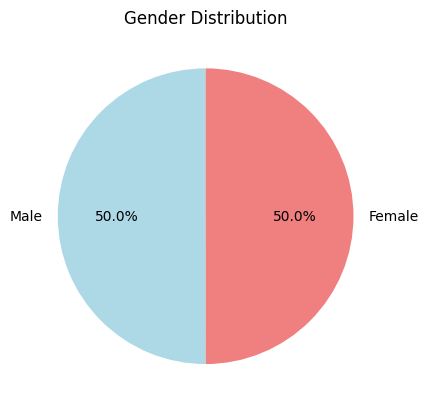

In [70]:

# 성별 레이블
labels = ['Male', 'Female']

# 성별 데이터의 수 계산
gender_count = origin_df['SEX'].value_counts()

# 원 그래프
plt.pie(gender_count, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Gender Distribution')
plt.show()

/var/folders/b0/ccbprr5n6mg42k66n3ldbj6w0000gn/T/ipykernel_89974/3768329606.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weight_means = df.groupby('Height_Group')['Weight'].mean()


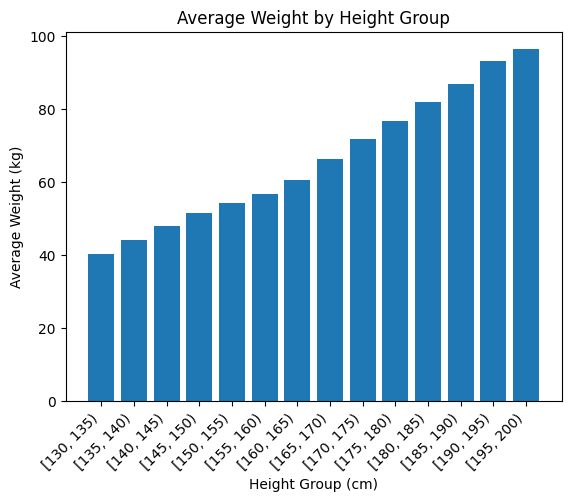

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 가상의 데이터프레임 생성 (키와 체중)
data = {'Height': origin_df['HEIGHT'],
        'Weight': origin_df['WEIGHT']}

df = pd.DataFrame(data)

# 키를 5cm 단위로 구간 나누기
bins = np.arange(df['Height'].min(), df['Height'].max() + 6, 5)

# 구간별로 데이터 나누기
df['Height_Group'] = pd.cut(df['Height'], bins, right=False)

# 구간별 체중 평균 계산
weight_means = df.groupby('Height_Group')['Weight'].mean()

# 막대 그래프 그리기
plt.bar(weight_means.index.astype(str), weight_means)
plt.xlabel('Height Group (cm)')
plt.ylabel('Average Weight (kg)')
plt.title('Average Weight by Height Group')
# x 축의 눈금 레이블을 45도 회전
plt.xticks(rotation=45, ha='right')

plt.show()


-> 이렇게 키가 클수록 평균 체중도 높으므로 이 둘의 데이터를 동시에 쓰는거보다는 BMI 지수를 생성하여 사용하는게 좋아보임

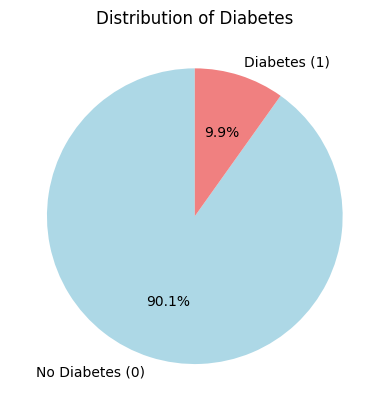

In [72]:
data = origin_df['D']
df = pd.DataFrame(data)

# 값의 분포 시각화 (원 그래프)
diabetes_count = df['D'].value_counts()
plt.pie(diabetes_count, labels=['No Diabetes (0)', 'Diabetes (1)'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Distribution of Diabetes')
plt.show()

-> 결과 당뇨인 사람과 아닌 사람의 비율을 맞추고 학습시켜야할 필요가 있어보임

In [73]:
origin_df = origin_df.dropna(subset=['TOT_CHOLE','TRIGLYCERIDE','HDL_CHOLE','LDL_CHOLE']) #콜레스트롤
origin_df = origin_df.dropna(subset=['BLDS'])
origin_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 417426 entries, 574465 to 999999
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   BLDS               417426 non-null  float64
 1   D                  417426 non-null  int64  
 2   SEX                417426 non-null  int64  
 3   AGE_GROUP          417426 non-null  int64  
 4   HEIGHT             417426 non-null  int64  
 5   WEIGHT             417426 non-null  int64  
 6   WAIST              417391 non-null  float64
 7   SIGHT_LEFT         417330 non-null  float64
 8   SIGHT_RIGHT        417334 non-null  float64
 9   HEAR_LEFT          417339 non-null  float64
 10  HEAR_RIGHT         417340 non-null  float64
 11  BP_HIGH            417419 non-null  float64
 12  BP_LWST            417418 non-null  float64
 13  TOT_CHOLE          417426 non-null  float64
 14  TRIGLYCERIDE       417426 non-null  float64
 15  HDL_CHOLE          417426 non-null  float64
 16  LD

In [74]:
origin_0 = origin_df.loc[origin_df['D'] == 0].head(40372)
origin_1 = origin_df.loc[origin_df['D'] == 1]
origin_df = pd.concat([origin_0, origin_1])
origin_df['D'].value_counts()

D
0    40372
1    40372
Name: count, dtype: int64

In [75]:
origin_df = origin_df.dropna(subset=['TOT_CHOLE','TRIGLYCERIDE','HDL_CHOLE','LDL_CHOLE','BLDS'])
origin_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80744 entries, 574465 to 999993
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BLDS               80744 non-null  float64
 1   D                  80744 non-null  int64  
 2   SEX                80744 non-null  int64  
 3   AGE_GROUP          80744 non-null  int64  
 4   HEIGHT             80744 non-null  int64  
 5   WEIGHT             80744 non-null  int64  
 6   WAIST              80740 non-null  float64
 7   SIGHT_LEFT         80722 non-null  float64
 8   SIGHT_RIGHT        80723 non-null  float64
 9   HEAR_LEFT          80730 non-null  float64
 10  HEAR_RIGHT         80730 non-null  float64
 11  BP_HIGH            80744 non-null  float64
 12  BP_LWST            80743 non-null  float64
 13  TOT_CHOLE          80744 non-null  float64
 14  TRIGLYCERIDE       80744 non-null  float64
 15  HDL_CHOLE          80744 non-null  float64
 16  LDL_CHOLE          80

In [76]:
origin_df['D'].value_counts()

D
0    40372
1    40372
Name: count, dtype: int64

In [100]:
origin_df.isnull().sum()

BLDS                     0
D                        0
SEX                      0
AGE_GROUP                0
HEIGHT                   0
WEIGHT                   0
WAIST                    4
SIGHT_LEFT              22
SIGHT_RIGHT             21
HEAR_LEFT               14
HEAR_RIGHT              14
BP_LWST                  1
TRIGLYCERIDE             0
HDL_CHOLE                0
LDL_CHOLE                0
HMG                      0
OLIG_PROTE_CD          565
CREATININE               0
SGOT_AST                 0
SGPT_ALT                 0
GAMMA_GTP                0
SMK_STAT_TYPE_CD        34
DRK_YN                  18
HCHK_OE_INSPEC_YN        0
CRS_YN               56984
TTR_YN               56984
BMI                      0
dtype: int64

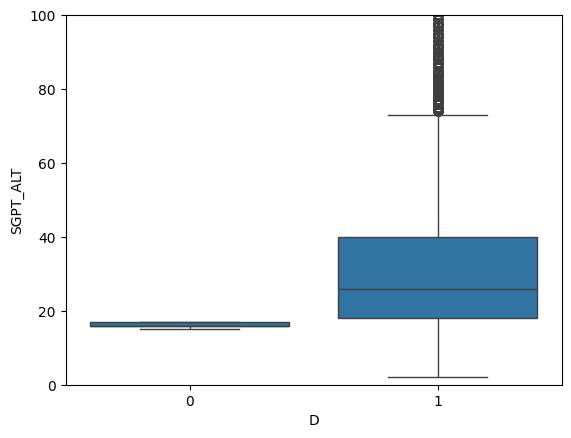

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.boxplot(x="D", y="SGPT_ALT", data=origin_df)
plt.ylim(0, 100)
plt.show()

In [104]:
origin_df['obesity'] = np.where(origin_df['BMI']>30, 1, 0)

In [105]:
origin_df

,BLDS,D,SEX,AGE_GROUP,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,HEAR_LEFT,...,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT_TYPE_CD,DRK_YN,HCHK_OE_INSPEC_YN,CRS_YN,TTR_YN,BMI,obesity
574465,94.0,0,2,11,140,50,72.0,0.0,0.0,1.0,...,21.0,16.0,17.0,1.0,0.0,0,NaN,NaN,25.510204,0
574466,117.0,0,1,16,165,55,80.0,0.0,0.0,1.0,...,21.0,16.0,29.0,1.0,0.0,0,NaN,NaN,20.202020,0
574467,91.0,0,1,10,180,80,84.0,1.0,0.0,1.0,...,21.0,16.0,22.0,3.0,1.0,0,NaN,NaN,24.691358,0
574470,89.0,0,2,9,160,50,76.0,1.0,1.0,1.0,...,21.0,16.0,19.0,1.0,1.0,0,NaN,NaN,19.531250,0
574474,98.0,0,2,9,165,55,69.0,0.0,1.0,1.0,...,21.0,16.0,18.0,1.0,1.0,0,NaN,NaN,20.202020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999978,130.0,1,2,13,155,80,104.0,1.0,0.0,1.0,...,134.0,186.0,46.0,1.0,0.0,0,NaN,NaN,33.298647,1
999981,156.0,1,2,11,155,55,80.0,0.0,0.0,1.0,...,76.0,109.0,48.0,1.0,0.0,1,1.0,0.0,22.892820,0
999982,153.0,1,2,13,150,65,97.0,1.0,1.0,1.0,...,141.0,176.0,86.0,1.0,0.0,0,NaN,NaN,28.888889,0
999983,130.0,1,2,13,155,95,112.0,0.0,0.0,1.0,...,98.0,120.0,274.0,1.0,0.0,0,NaN,NaN,39.542144,1


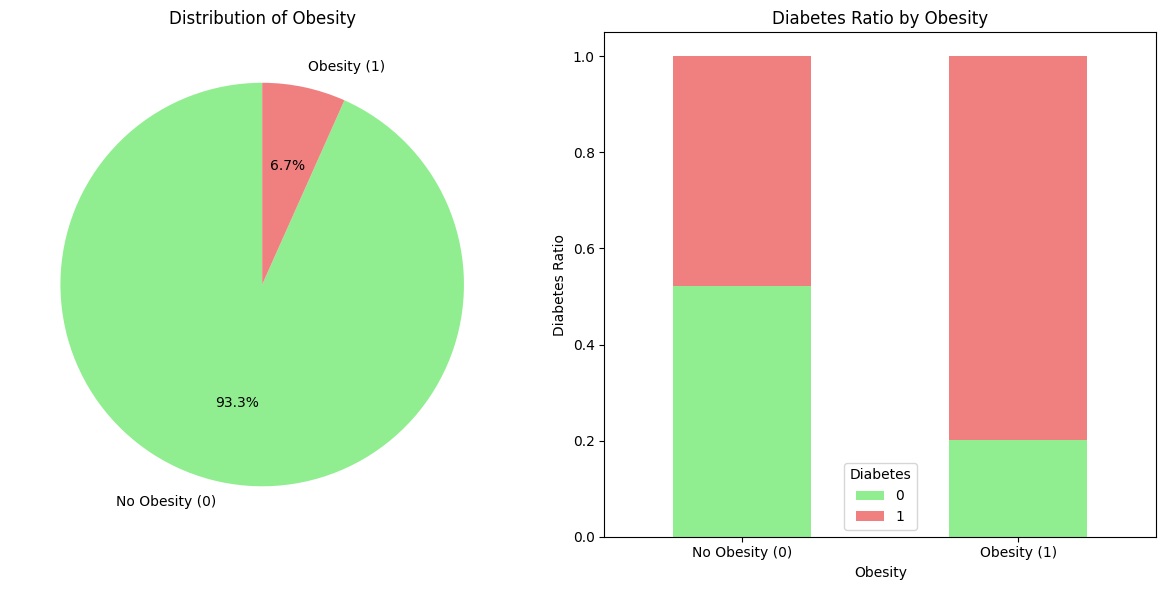

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 가상의 데이터프레임 생성 (비만 여부, 당뇨 여부)
data = {'Obesity': origin_df['obesity'],
        'Diabetes': origin_df['D']}

df = pd.DataFrame(data)

# 비만 여부에 따른 당뇨 비율 시각화 (파이 차트)
obesity_count = df['Obesity'].value_counts()
diabetes_by_obesity = df.groupby('Obesity')['Diabetes'].value_counts(normalize=True).unstack()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# 파이 차트
axes[0].pie(obesity_count, labels=['No Obesity (0)', 'Obesity (1)'], autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
axes[0].set_title('Distribution of Obesity')

# 비만 여부에 따른 당뇨 비율
diabetes_by_obesity.plot(kind='bar', stacked=True, ax=axes[1], color=['lightgreen', 'lightcoral'])
axes[1].set_xticklabels(['No Obesity (0)', 'Obesity (1)'], rotation=0)
axes[1].set_ylabel('Diabetes Ratio')
axes[1].set_title('Diabetes Ratio by Obesity')

plt.tight_layout()
plt.show()


In [107]:
origin_df['Hypertension'] = np.where(origin_df['BP_LWST'] >= 90, 1, 0)
origin_df['Hypertension'].value_counts()

Hypertension
0    72858
1     7886
Name: count, dtype: int64

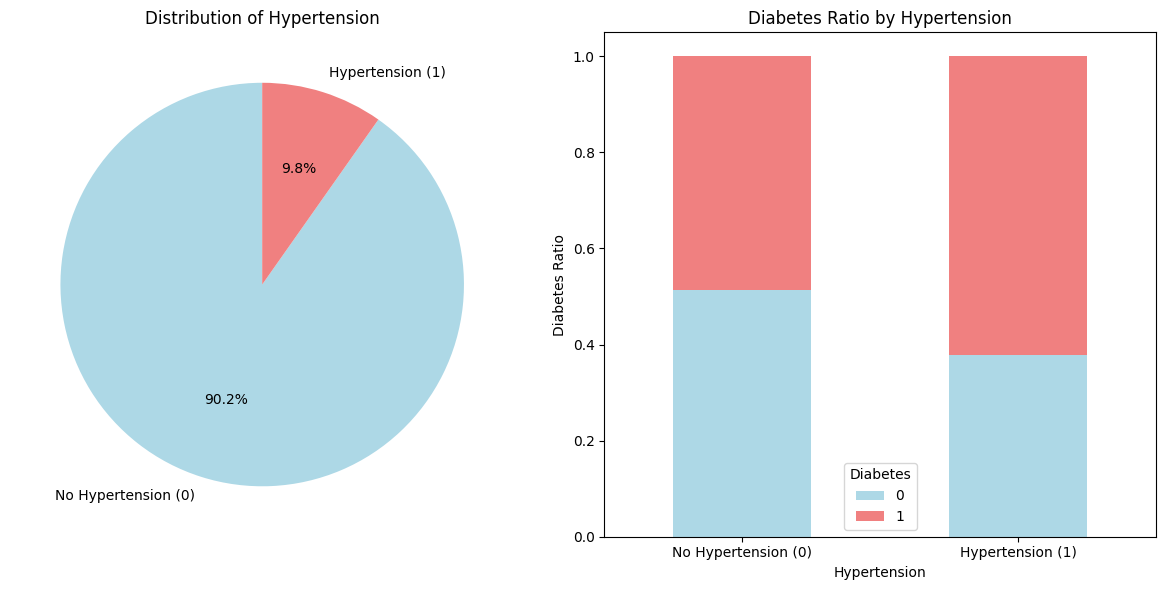

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 가상의 데이터프레임 생성 (고혈압 여부, 뇌졸증 여부)
data = {'Hypertension': origin_df['Hypertension'],
        'Diabetes': origin_df['D']}

df = pd.DataFrame(data)

# 고혈압 여부에 따른 뇌졸증 비율 시각화 (파이 차트)
hypertension_count = df['Hypertension'].value_counts()
stroke_by_hypertension = df.groupby('Hypertension')['Diabetes'].value_counts(normalize=True).unstack()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# 파이 차트
axes[0].pie(hypertension_count, labels=['No Hypertension (0)', 'Hypertension (1)'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
axes[0].set_title('Distribution of Hypertension')

# 고혈압 여부에 따른 뇌졸증 비율
stroke_by_hypertension.plot(kind='bar', stacked=True, ax=axes[1], color=['lightblue', 'lightcoral'])
axes[1].set_xticklabels(['No Hypertension (0)', 'Hypertension (1)'], rotation=0)
axes[1].set_ylabel('Diabetes Ratio')
axes[1].set_title('Diabetes Ratio by Hypertension')

plt.tight_layout()
plt.show()


In [110]:
origin_df.describe()

,BLDS,D,SEX,AGE_GROUP,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,HEAR_LEFT,...,SGPT_ALT,GAMMA_GTP,SMK_STAT_TYPE_CD,DRK_YN,HCHK_OE_INSPEC_YN,CRS_YN,TTR_YN,BMI,obesity,Hypertension
count,80744.000000,80744.000000,80744.000000,80744.000000,80744.000000,80744.000000,80740.000000,80722.000000,80723.000000,80730.000000,...,80744.000000,80744.000000,80710.000000,80726.000000,80744.000000,23760.000000,23760.000000,80744.000000,80744.000000,80744.000000
mean,127.478438,0.500000,1.517586,12.404748,160.232401,62.842626,82.926839,0.432571,0.439119,1.058590,...,25.062271,38.205551,1.534717,0.537869,0.294263,0.164646,0.583081,24.371563,0.066828,0.097667
std,42.513164,0.500003,0.499694,2.314068,9.129069,12.429144,9.976392,0.775914,0.790509,0.244977,...,24.498667,83.881361,0.777828,0.498567,0.455714,0.370869,0.598903,3.735744,0.249726,0.296865
min,43.000000,0.000000,1.000000,9.000000,130.000000,30.000000,50.000000,0.000000,0.000000,1.000000,...,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.486993,0.000000,0.000000
25%,96.000000,0.000000,1.000000,10.000000,155.000000,55.000000,76.000000,0.000000,0.000000,1.000000,...,16.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,22.038567,0.000000,0.000000
50%,126.500000,0.500000,2.000000,13.000000,160.000000,60.000000,83.000000,0.000000,0.000000,1.000000,...,17.000000,23.000000,1.000000,1.000000,0.000000,0.000000,1.000000,23.875115,0.000000,0.000000
75%,144.000000,1.000000,2.000000,14.000000,165.000000,70.000000,89.000000,1.000000,1.000000,1.000000,...,26.000000,38.000000,2.000000,1.000000,1.000000,0.000000,1.000000,26.666667,0.000000,0.000000
max,779.000000,1.000000,2.000000,18.000000,195.000000,135.000000,147.000000,9.000000,9.000000,3.000000,...,3244.000000,9999.000000,3.000000,1.000000,1.000000,1.000000,2.000000,53.571429,1.000000,1.000000


In [134]:
origin_df['liver'] = np.where(origin_df['SGPT_ALT'] > 40, 1, 0)
origin_df['liver'].value_counts()

liver
0    71118
1     9626
Name: count, dtype: int64

In [135]:
origin_df['sick_liver'] = np.where(origin_df['SGOT_AST'] > 40, 1, 0)
origin_df['sick_liver'].value_counts()

sick_liver
0    73237
1     7507
Name: count, dtype: int64

In [129]:
origin_df

,BLDS,D,SEX,AGE_GROUP,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,HEAR_LEFT,...,SMK_STAT_TYPE_CD,DRK_YN,HCHK_OE_INSPEC_YN,CRS_YN,TTR_YN,BMI,obesity,Hypertension,Fat_liver,liver
574465,94.0,0,2,11,140,50,72.0,0.0,0.0,1.0,...,1.0,0.0,0,NaN,NaN,25.510204,0,0,0,0
574466,117.0,0,1,16,165,55,80.0,0.0,0.0,1.0,...,1.0,0.0,0,NaN,NaN,20.202020,0,0,0,0
574467,91.0,0,1,10,180,80,84.0,1.0,0.0,1.0,...,3.0,1.0,0,NaN,NaN,24.691358,0,0,0,0
574470,89.0,0,2,9,160,50,76.0,1.0,1.0,1.0,...,1.0,1.0,0,NaN,NaN,19.531250,0,0,0,0
574474,98.0,0,2,9,165,55,69.0,0.0,1.0,1.0,...,1.0,1.0,0,NaN,NaN,20.202020,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999978,130.0,1,2,13,155,80,104.0,1.0,0.0,1.0,...,1.0,0.0,0,NaN,NaN,33.298647,1,0,0,1
999981,156.0,1,2,11,155,55,80.0,0.0,0.0,1.0,...,1.0,0.0,1,1.0,0.0,22.892820,0,1,0,1
999982,153.0,1,2,13,150,65,97.0,1.0,1.0,1.0,...,1.0,0.0,0,NaN,NaN,28.888889,0,1,0,1
999983,130.0,1,2,13,155,95,112.0,0.0,0.0,1.0,...,1.0,0.0,0,NaN,NaN,39.542144,1,0,0,1


In [130]:
origin_df.iloc[:, -1]

574465    0
574466    0
574467    0
574470    0
574474    0
         ..
999978    1
999981    1
999982    1
999983    1
999993    1
Name: liver, Length: 80744, dtype: int64

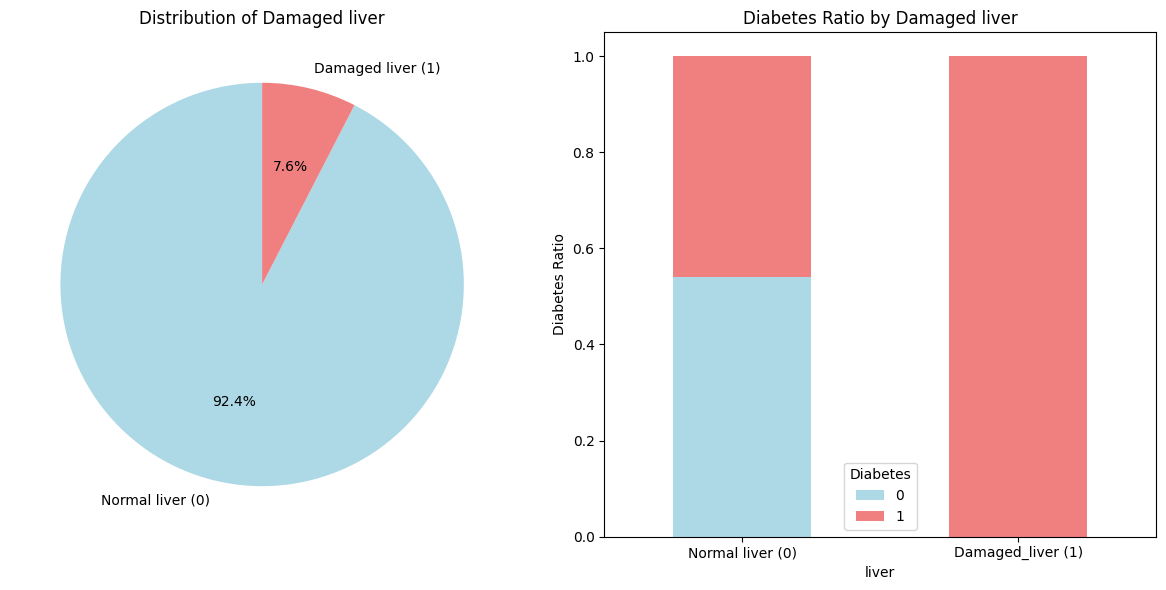

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 가상의 데이터프레임 생성 (고혈압 여부, 뇌졸증 여부)
data = {'liver': origin_df.iloc[:, -1],
        'Diabetes': origin_df['D']}

df = pd.DataFrame(data)

# 고혈압 여부에 따른 뇌졸증 비율 시각화 (파이 차트)
hypertension_count = df['liver'].value_counts()
stroke_by_hypertension = df.groupby('liver')['Diabetes'].value_counts(normalize=True).unstack()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# 파이 차트
axes[0].pie(hypertension_count, labels=['Normal liver (0)', 'Damaged liver (1)'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
axes[0].set_title('Distribution of Damaged liver')

# 고혈압 여부에 따른 뇌졸증 비율
stroke_by_hypertension.plot(kind='bar', stacked=True, ax=axes[1], color=['lightblue', 'lightcoral'])
axes[1].set_xticklabels(['Normal liver (0)', 'Damaged_liver (1)'], rotation=0)
axes[1].set_ylabel('Diabetes Ratio')
axes[1].set_title('Diabetes Ratio by Damaged liver')

plt.tight_layout()
plt.show()


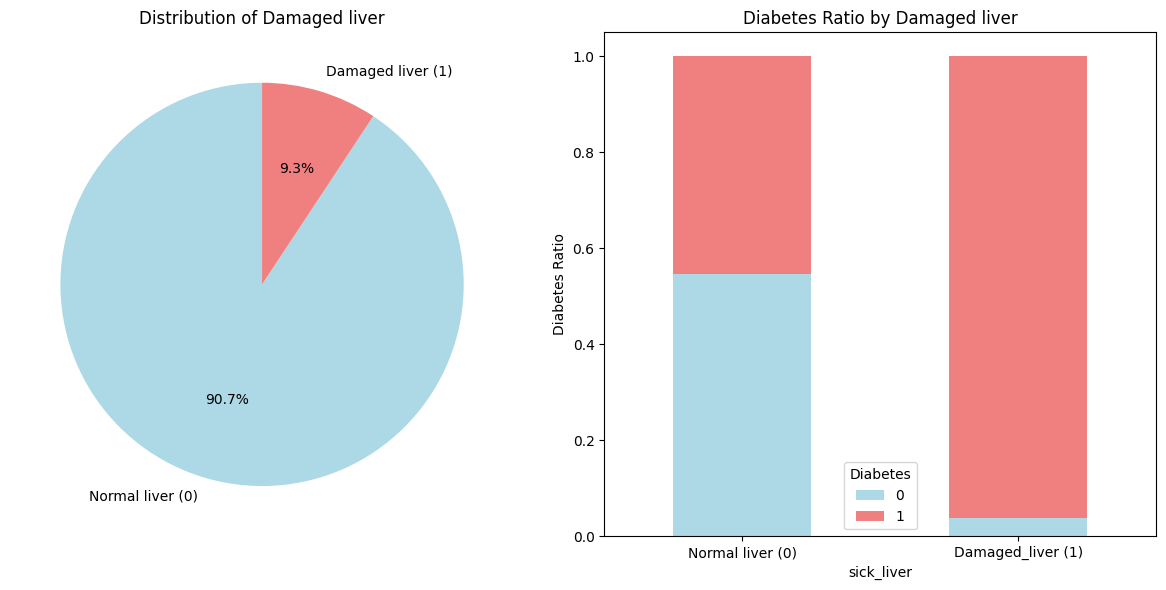

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 가상의 데이터프레임 생성 (고혈압 여부, 뇌졸증 여부)
data = {'sick_liver': origin_df['sick_liver'],
        'Diabetes': origin_df['D']}

df = pd.DataFrame(data)

# 고혈압 여부에 따른 뇌졸증 비율 시각화 (파이 차트)
hypertension_count = df['sick_liver'].value_counts()
stroke_by_hypertension = df.groupby('sick_liver')['Diabetes'].value_counts(normalize=True).unstack()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# 파이 차트
axes[0].pie(hypertension_count, labels=['Normal liver (0)', 'Damaged liver (1)'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
axes[0].set_title('Distribution of Damaged liver')

# 고혈압 여부에 따른 뇌졸증 비율
stroke_by_hypertension.plot(kind='bar', stacked=True, ax=axes[1], color=['lightblue', 'lightcoral'])
axes[1].set_xticklabels(['Normal liver (0)', 'Damaged_liver (1)'], rotation=0)
axes[1].set_ylabel('Diabetes Ratio')
axes[1].set_title('Diabetes Ratio by Damaged liver')

plt.tight_layout()
plt.show()


- 일단 타겟인 'D'(=종속변수)와 나머지 피처들이 상관관계를 얼마나 갖는지 파악하기 위해 heatmap 작성

<Axes: >

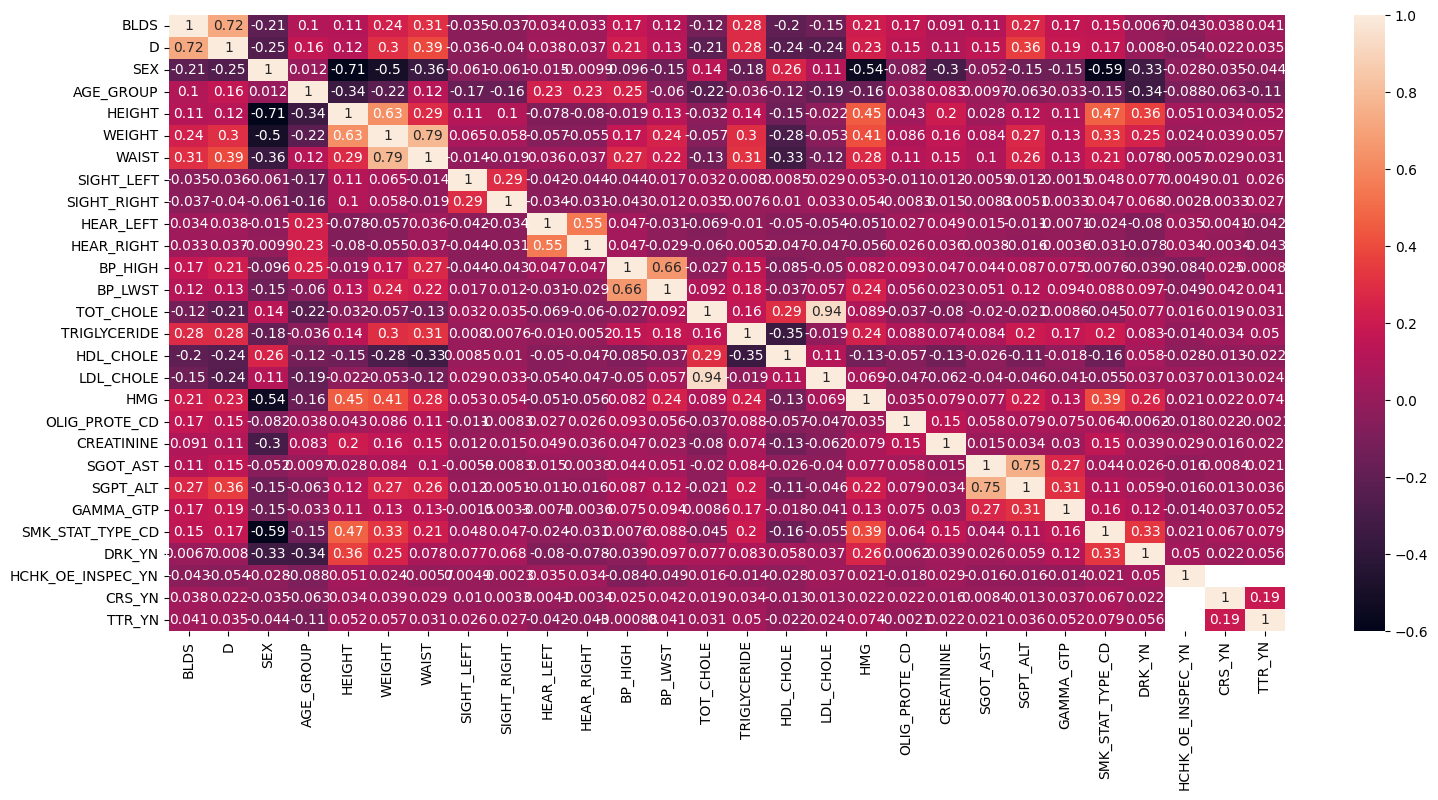

In [78]:
#plt.show()
plt.figure(figsize=(18,8))
corr = origin_df.corr()
#print(corr)
sns.heatmap(corr, annot=True, square=False, vmin=-0.6, vmax=1.0)

## Data Preprocessing

### Feature Engineering

- 종속변수와 상관관계가 아주 낮은 변수들은 학습에 끼치는 영향이 미미할 것이므로 삭제
- 또한 종속변수와 상관관계가 아닌 독립변수들끼리 상관관계 계수가 높을수록 모델 성능에 영향을 끼칠 수 있으므로 변수들끼리 통합하여 새로운 피처를 만들거나 제거

- 예를 들어 히트맵에서 HEIGHT, WEIGHT, WAIST 끼리의 상관관계 계수가 높아서 BMI 지수를 새로 만들고 삭제
- BP_HIGH, BP_LWST 도 서로 상관관계가 높으므로 당뇨와 더 관련이 있는 BP_LWST만 사용
- 콜레스테롤 데이터 중에 TOT를 제외하면 독립변수들끼리 상관관계가 계수가 그닥 높지 않으므로 TOT만 제거

In [79]:
origin_df = origin_df.drop(['TOT_CHOLE'], axis=1)

In [80]:
origin_df['BMI'] = origin_df['WEIGHT'] / ((origin_df['HEIGHT'])/100)**2
origin_df = origin_df.drop(['BP_HIGH'],axis=1)
origin_df = origin_df.drop(['TOT_CHOLE'], axis=1)

KeyError: "['TOT_CHOLE'] not found in axis"

In [ ]:
origin_df.head()

,BLDS,D,SEX,AGE_GROUP,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,HEAR_LEFT,...,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT_TYPE_CD,DRK_YN,HCHK_OE_INSPEC_YN,CRS_YN,TTR_YN,BMI
0,93.0,0,2,12,160,60,79.0,0.0,0.0,1.0,...,0.0,23.0,21.0,23.0,1.0,0.0,0,NaN,NaN,23.437500
1,108.0,0,2,11,160,60,74.0,0.0,0.0,1.0,...,0.0,22.0,21.0,12.0,1.0,1.0,0,NaN,NaN,23.437500
2,104.0,0,2,9,150,60,72.0,0.0,0.0,1.0,...,0.0,18.0,26.0,70.0,1.0,1.0,0,NaN,NaN,26.666667
3,146.0,1,2,16,150,60,86.0,0.0,0.0,1.0,...,0.0,17.0,9.0,24.0,1.0,0.0,0,NaN,NaN,26.666667
4,90.0,0,2,13,155,60,66.0,0.0,0.0,1.0,...,0.0,27.0,19.0,12.0,1.0,1.0,0,NaN,NaN,24.973985


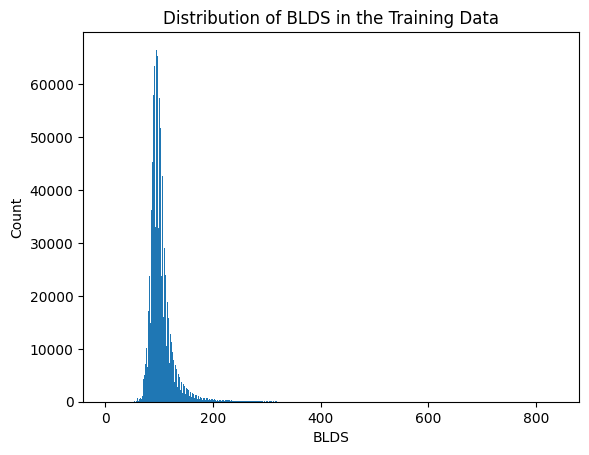

In [ ]:
plt.hist(origin_df.BLDS, bins=500)
plt.xlabel('BLDS')
plt.ylabel('Count')
plt.title('Distribution of BLDS in the Training Data')
plt.show()

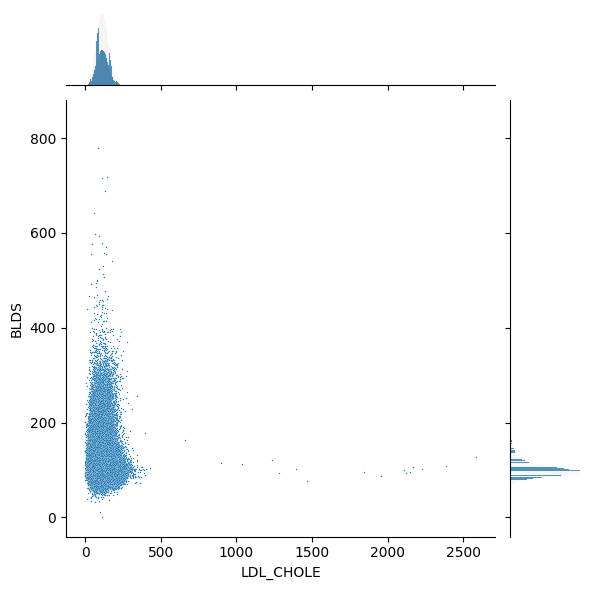

In [ ]:
sns.jointplot(x='LDL_CHOLE', y='BLDS', data=origin_df, s = 1)

joint

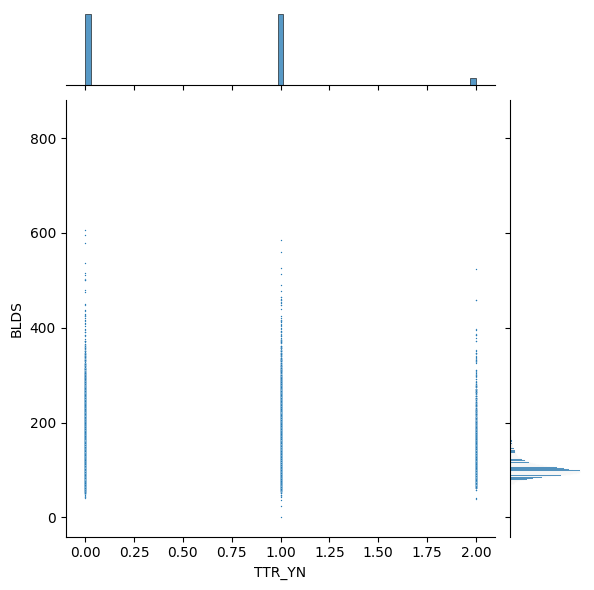

In [ ]:
sns.jointplot(x='TTR_YN', y='BLDS', data=origin_df, s = 1)

- TTR_YN (치석 유무) 단계별로 BLDS가 고르게 분포하므로 별다른 의미를 찾기엔 힘들어 보임 -> drop

In [ ]:
origin_df = origin_df.drop(['TTR_YN'],axis=1)

In [ ]:
오늘 여기까지 하시죠